# Perform error analysis across collaborative tests and activities.


In [1]:
import pathlib as pl
import pickle
import pandas as pd
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
#import wilcoxon signed-rank
from scipy.stats import wilcoxon, shapiro, ttest_rel, stats
#import cliffs delta
from effsize.effsize import two_group_difference

# Define paths.

In [2]:
processed_tables_pickle_file = pl.Path(
    '../processed_data/processed_tables.pickle')
collab_best_pickle_file = pl.Path(
    '../processed_data/collab_best_df.pickle')

# Load pickled data.

In [3]:
with processed_tables_pickle_file.open('rb') as handle:
    processed_tables = pickle.load(handle)

In [4]:
processed_tables.keys()
pd.options.display.max_columns = None
df = processed_tables[10]
df = df.loc[df['header.frame_id'] == 'collab-activity-2']
# df

# 1 Error over collab activity success.

### Cleaning Tables.

In [5]:
# formatting dataframe for error over best collaborative activity success
def clean_tables():
    student_tables = {}
    for student, df in processed_tables.items():
        #list of maximum error values for each activity
        max_error = []

        df = df.copy()
        df = df[df['is_submission']]

        df.drop(['Time', 'header.seq', 'state.edges', 'state.suggested.u', 'state.suggested.v', 'state.terminal', 'state.submit_suggested', 'action.type', 'action.edge.u', 'action.edge.v', 'turn_agent', 'next_state.edges', 'next_state.suggested.u', 'next_state.suggested.v',
                'next_state.terminal', 'next_state.submit_suggested', 'action_no', 'step_no'], axis=1, inplace=True)

        # removing collaborative activity rows
#         df = df[df['header.frame_id'] != "collab-activity"]
#         df = df[df['header.frame_id'] != "collab-activity-2"]
        # removing duplicate rows from submission log and keeping the last submission
#         df.drop_duplicates(subset="header.frame_id",
#                            keep='last', inplace=True)

        # preserving collaborative activity rows while removing duplicate test rows
        df = pd.concat([
            df[df['header.frame_id'] == 'collab-activity'],
            df[df['header.frame_id'] == 'collab-activity-2'],
            df[(df['header.frame_id'] != 'collab-activity') & (df['header.frame_id'] !=
                                                               'collab-activity-2')].drop_duplicates(['header.frame_id'], keep='last')
        ])

        mst_costs = []
        spanning = []
        norm_error = []

        for i, row in df.iterrows():
            cost = row['world_state'].get_mst_cost()
            span = row['world_state'].is_spanning()
            mst_costs.append(cost)
            spanning.append(span)
            # compute normalized error
            if span:
                norm_error.append((int(row['cost']) - int(row['world_state'].get_mst_cost())) /
                                  int(row['world_state'].get_mst_cost()))
                max_error.append((int(row['world_state'].get_max_cost()) - int(row['world_state'].get_mst_cost())) /
                                  int(row['world_state'].get_mst_cost()))
            else:
                norm_error.append(None)

        # adding mst_cost, spanning, and normalized_error columns
        df['mst_cost'] = mst_costs
        df['spanning'] = spanning
        df['normalized_error'] = norm_error

        student_tables[student] = df

        print("STUDENT", student)
#         display(df)
    return student_tables, max_error


all_tables, max_error = clean_tables()
print(max_error)

STUDENT 6
STUDENT 1
STUDENT 9
STUDENT 7
STUDENT 2
STUDENT 5
STUDENT 4
STUDENT 3
STUDENT 10
[1.9090909090909092, 2.085714285714286, 1.6, 1.6, 1.4285714285714286, 1.2, 1.6, 1.6, 1.6, 1.4285714285714286, 1.2, 1.6]


### Formatting collab submissions dataframe.

In [6]:
# formatting dataframe for collab activities only
cdf = pd.DataFrame()

#dictionary containing all collaborative attempts by each student
collab_attempts = {}

for key, mdf in all_tables.items():
    collab_df = mdf.loc[mdf['header.frame_id'].isin(
        ['collab-activity', 'collab-activity-2'])].copy()
    collab_df['student'] = key
    collab_df.drop(columns=['world_state', 'is_submission', 'is_mst', 'cost', 'mst_cost', 'spanning', 'action'
                            ], inplace=True)
    collab_df.rename(columns={"header.frame_id": "activity",
                     "action.agent_name": "agent", "normalized_error": "error"}, inplace=True)
    cdf = cdf.append(collab_df)
    collab_attempts[key] = collab_df
    
# dataframe containing all collaborative activity submissions 
cdf

,activity,agent,error,student
93,collab-activity,human,0.772727,6
103,collab-activity,robot,NaN,6
109,collab-activity,robot,NaN,6
118,collab-activity,robot,NaN,6
153,collab-activity,human,0.772727,6
181,collab-activity-2,human,0.542857,6
182,collab-activity-2,human,NaN,6
211,collab-activity-2,human,NaN,6
231,collab-activity-2,human,NaN,6
81,collab-activity,robot,0.727273,1


### Filtering human submissions.

In [7]:
# dataframe containing only human collaborative activity submissions
cdf_human = pd.DataFrame()

# removing robot submissions
for index, row in cdf.iterrows():
    cdf_human = cdf.loc[cdf['agent'].isin(
        ['human'])].copy()

display(cdf_human)

# reformatting dataframes with only human submissions so they are activity specific

collab_df_1 = cdf_human.loc[cdf_human['activity'].isin(
    ['collab-activity'])].copy()

collab_df_2 = cdf_human.loc[cdf_human['activity'].isin(
    ['collab-activity-2'])].copy()

display(collab_df_1)
display(collab_df_2)

,activity,agent,error,student
93,collab-activity,human,0.772727,6
153,collab-activity,human,0.772727,6
181,collab-activity-2,human,0.542857,6
182,collab-activity-2,human,NaN,6
211,collab-activity-2,human,NaN,6
231,collab-activity-2,human,NaN,6
105,collab-activity,human,0.318182,1
155,collab-activity,human,0.454545,1
220,collab-activity-2,human,0.342857,1
245,collab-activity-2,human,0.000000,1


,activity,agent,error,student
93,collab-activity,human,0.772727,6
153,collab-activity,human,0.772727,6
105,collab-activity,human,0.318182,1
155,collab-activity,human,0.454545,1
109,collab-activity,human,0.454545,9
143,collab-activity,human,0.727273,9
167,collab-activity,human,0.045455,9
65,collab-activity,human,NaN,7
93,collab-activity,human,0.000000,7
116,collab-activity,human,0.000000,2


,activity,agent,error,student
181,collab-activity-2,human,0.542857,6
182,collab-activity-2,human,NaN,6
211,collab-activity-2,human,NaN,6
231,collab-activity-2,human,NaN,6
220,collab-activity-2,human,0.342857,1
245,collab-activity-2,human,0.000000,1
225,collab-activity-2,human,0.342857,9
253,collab-activity-2,human,0.000000,9
116,collab-activity-2,human,NaN,7
143,collab-activity-2,human,NaN,7


### Filtering best submissions.

In [8]:

# making a new dataframe that only contains the best submissions in each activity per student

# takes a dataframe containing rows of submissions and returns a dataframe with the best submissions
def bestDf(df):

    best_df = pd.DataFrame()
    bdf = df.copy()
    current = bdf.iloc[[0][0]]['student']
    temp_dict = {}
    temp_df = pd.DataFrame()

    for index, row in bdf.iterrows():
        #print('current student', current)
        if current == row['student']:
            # compare the errors of every student so that we select the best in each activity
            # add them to a new df
            temp_df = temp_df.append(row)
            # sort based on error value
            temp_df.sort_values(
                by=['error'], inplace=True, ascending=True, na_position='last', ignore_index=True)

            # gets the dataframe row with the lowest error and adds it to a temporary dictionary
            # update dictionary with key as student, value as the temp df where the first row is the best
            temp_dict[current] = temp_df.iloc[0]
            #display(temp_df)
        else:
            current = row['student']
            temp_df = pd.DataFrame()
            
            # figure out how to compare the errors of every student so that we select the best in each activity
            # add them to a new df
            temp_df = temp_df.append(row)
            # sort based on error value
            temp_df.sort_values(
                by=['error'], inplace=True, ascending=True, na_position='last', ignore_index=True)

            # gets the dataframe row with the lowest error and adds it to a temporary dictionary
            # update dictionary with key as student, value as the temp df where the first row is the best
            temp_dict[current] = temp_df.iloc[0]
            #display(temp_df)

    # display(temp_dict)

    # now need to loop through the dictionary and for every item, the first row in the value is the best submission
    for student, temp in temp_dict.items():
        # appending best submission to best_df
        # display(temp)
        temp.name = student
        best_df = best_df.append(temp)
    return best_df


bestDf(collab_df_1)

,activity,agent,error,student
6,collab-activity,human,0.772727,6.0
1,collab-activity,human,0.318182,1.0
9,collab-activity,human,0.045455,9.0
7,collab-activity,human,0.000000,7.0
2,collab-activity,human,0.000000,2.0
5,collab-activity,human,0.318182,5.0
4,collab-activity,human,0.318182,4.0
3,collab-activity,human,0.000000,3.0
10,collab-activity,human,0.000000,10.0


### Creating best dataframes for visualization.

In [9]:
collab_dfs = [collab_df_1, collab_df_2]

collab_best = pd.DataFrame()

# creating dataframes with the best submission of each collaborative activity for every student
for df in collab_dfs:
    best = bestDf(df)
    display(best)
    collab_best = collab_best.append(best)

collab_best.drop(columns=['agent'], inplace=True)
collab_best

,activity,agent,error,student
6,collab-activity,human,0.772727,6.0
1,collab-activity,human,0.318182,1.0
9,collab-activity,human,0.045455,9.0
7,collab-activity,human,0.000000,7.0
2,collab-activity,human,0.000000,2.0
5,collab-activity,human,0.318182,5.0
4,collab-activity,human,0.318182,4.0
3,collab-activity,human,0.000000,3.0
10,collab-activity,human,0.000000,10.0


,activity,agent,error,student
6,collab-activity-2,human,0.542857,6.0
1,collab-activity-2,human,0.000000,1.0
9,collab-activity-2,human,0.000000,9.0
7,collab-activity-2,human,NaN,7.0
2,collab-activity-2,human,0.000000,2.0
5,collab-activity-2,human,0.000000,5.0
4,collab-activity-2,human,0.000000,4.0
3,collab-activity-2,human,0.057143,3.0
10,collab-activity-2,human,0.000000,10.0


,activity,error,student
6,collab-activity,0.772727,6.0
1,collab-activity,0.318182,1.0
9,collab-activity,0.045455,9.0
7,collab-activity,0.000000,7.0
2,collab-activity,0.000000,2.0
5,collab-activity,0.318182,5.0
4,collab-activity,0.318182,4.0
3,collab-activity,0.000000,3.0
10,collab-activity,0.000000,10.0
6,collab-activity-2,0.542857,6.0


In [10]:
with collab_best_pickle_file.open('wb') as handle:
    pickle.dump(collab_best, handle, protocol=pickle.HIGHEST_PROTOCOL)

print('Saved collab_best dataframe to {}'.format(collab_best_pickle_file))

Saved collab_best dataframe to ../processed_data/collab_best_df.pickle


### Visualization of error over collab activity by best submission.

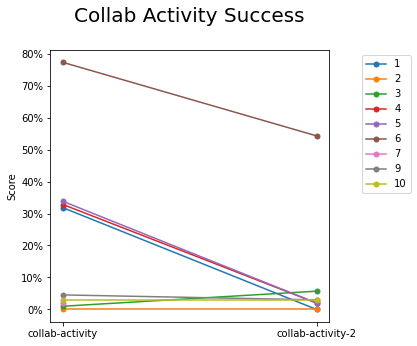

In [11]:
# visualization for error evolution over the best submission in each collaborative activity
students = [1, 2, 3, 4, 5, 6, 7, 9, 10]
separation = 0.01

# graphing the pretest versus posttest is_spanning scores
fig, ax = plt.subplots(1, figsize=(5, 5))

prelist = list()
postlist = list()
for i in students:
    temp = collab_best[collab_best['student'] == i]
    values = list(temp.error)
    #computing offset between overlapping lines
    p0 = values[0] + prelist.count(values[0])*separation
    p1 = values[1] + prelist.count(values[1])*separation
    prelist.append(values[0])
    postlist.append(values[1])
    #plotting
    plt.plot(temp.activity, [p0,p1], marker='o', markersize=5)
plt.ylabel('Score')
plt.title('Collab Activity Success\n', loc='center', fontsize=20)

leg = plt.legend(students, loc='upper left', frameon=True)
# get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
# change to location of the legend
xOffset = 1.1
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform=ax.transAxes)

# set y axis ticks to percentages
yticks = plt.yticks()[0]
plt.yticks(yticks[1:-1], [str(round(i*100)) + '%' for i in yticks[1:-1]])
plt.show()


## Compute temporal dynamics accross collaborative activities.

- Compare errors of best attempt in activity 1 vs. best attempt in activity 2 by Wilcoxon’s, and compute effect size Cliff’s Delta) (extension of notebook 3)
    - evolution overall significant if Wilcoxon’s says p < 0.05. 
    - Direction (improve or not) by Cliff’s Delta’s sign.
- Note: must be spanning, for collaborative activities
- report Magnitude overall: Cliff’s Delta’s absolute value (large, small, negligible, etc.)


### Reformatting best error dataframe. 

In [12]:
def reformat_collab_df(df):

    c_data = {}
    c2_data = {}

    for index, row in df.iterrows():
        if row['activity'] == 'collab-activity':
            if int(row['student']) not in c_data.keys():
                c_data[int(row['student'])] = row['error']
        if row['activity'] == 'collab-activity-2':
            if int(row['student']) not in c2_data.keys():
                c2_data[int(row['student'])] = row['error']

    df1 = pd.DataFrame.from_dict(
        data=c_data, orient='index', columns=['collab_error_1'])
    df2 = pd.DataFrame.from_dict(
        data=c2_data, orient='index', columns=['collab_error_2'])

    final_df = pd.merge(df1, df2, left_index=True, right_index=True)
    final_df['student'] = final_df.index
    return final_df


df = reformat_collab_df(collab_best)

### Perform Wilcoxon signed-rank test.

In [13]:
r = list(df['collab_error_1'])
o = list(df['collab_error_2'])
w, p = wilcoxon(r, o, mode="exact")
# null hypotehsis says they are the same, p val less than threshold, reject hyp, conclude that post is larger than pretest
print('Exact:', 'W=', w, 'pvalue=', p)
a, b = wilcoxon(r, o, mode="exact", alternative="greater")
print('Greater:', 'W=', a, 'pvalue=', b)

Exact: W= 2.0 pvalue= 0.04105088656045887
Greater: W= 19.0 pvalue= 0.1973134331215476


/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/venv/lib/python3.7/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/venv/lib/python3.7/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


### Compute effect size Cliff's Deltas.

In [14]:
r = list(df['collab_error_1'])
o = list(df['collab_error_2'])
# estimate effect size by Cliff's Delta 
d = two_group_difference(control=r, test=o, effect_size='cliffs_delta')
print('d', d)


d -0.3055555555555556


# 2 Error over collab activity by attempt.

In [15]:
custom_xticks = {}
for student, df in collab_attempts.items():
    # add attempt number column for graph
    df.reset_index(drop=True, inplace=True)
    df['attempt'] = df.index + 1
    count = 1
    labels = []
    for index, row in df.iterrows():
        if row['activity'] == 'collab-activity-2':
            # attempt = count
            # df.at[index,'attempt'] = attempt
            labels.append(count)
            count += 1
        else:
            labels.append(row['attempt'])
    custom_xticks[student] = labels
    display(df)

,activity,agent,error,student,attempt
0,collab-activity,human,0.772727,6,1
1,collab-activity,robot,NaN,6,2
2,collab-activity,robot,NaN,6,3
3,collab-activity,robot,NaN,6,4
4,collab-activity,human,0.772727,6,5
5,collab-activity-2,human,0.542857,6,6
6,collab-activity-2,human,NaN,6,7
7,collab-activity-2,human,NaN,6,8
8,collab-activity-2,human,NaN,6,9


,activity,agent,error,student,attempt
0,collab-activity,robot,0.727273,1,1
1,collab-activity,human,0.318182,1,2
2,collab-activity,robot,0.318182,1,3
3,collab-activity,human,0.454545,1,4
4,collab-activity-2,robot,NaN,1,5
5,collab-activity-2,human,0.342857,1,6
6,collab-activity-2,human,0.000000,1,7


,activity,agent,error,student,attempt
0,collab-activity,human,0.454545,9,1
1,collab-activity,human,0.727273,9,2
2,collab-activity,human,0.045455,9,3
3,collab-activity,robot,0.590909,9,4
4,collab-activity-2,human,0.342857,9,5
5,collab-activity-2,human,0.000000,9,6


,activity,agent,error,student,attempt
0,collab-activity,human,NaN,7,1
1,collab-activity,human,0.0,7,2
2,collab-activity-2,human,NaN,7,3
3,collab-activity-2,human,NaN,7,4
4,collab-activity-2,human,NaN,7,5
5,collab-activity-2,human,NaN,7,6


,activity,agent,error,student,attempt
0,collab-activity,human,0.0,2,1
1,collab-activity-2,human,0.2,2,2
2,collab-activity-2,human,NaN,2,3
3,collab-activity-2,human,NaN,2,4
4,collab-activity-2,human,NaN,2,5
5,collab-activity-2,human,NaN,2,6
6,collab-activity-2,human,0.0,2,7


,activity,agent,error,student,attempt
0,collab-activity,robot,0.727273,5,1
1,collab-activity,robot,0.409091,5,2
2,collab-activity,human,0.318182,5,3
3,collab-activity,human,NaN,5,4
4,collab-activity-2,human,0.000000,5,5


,activity,agent,error,student,attempt
0,collab-activity,human,0.454545,4,1
1,collab-activity,human,0.318182,4,2
2,collab-activity,human,0.363636,4,3
3,collab-activity,human,NaN,4,4
4,collab-activity-2,robot,NaN,4,5
5,collab-activity-2,human,NaN,4,6
6,collab-activity-2,human,0.000000,4,7


,activity,agent,error,student,attempt
0,collab-activity,robot,0.363636,3,1
1,collab-activity,human,0.318182,3,2
2,collab-activity,human,0.000000,3,3
3,collab-activity-2,robot,NaN,3,4
4,collab-activity-2,human,0.057143,3,5
5,collab-activity-2,human,0.114286,3,6
6,collab-activity-2,robot,0.057143,3,7


,activity,agent,error,student,attempt
0,collab-activity,human,0.0,10,1
1,collab-activity-2,human,0.0,10,2


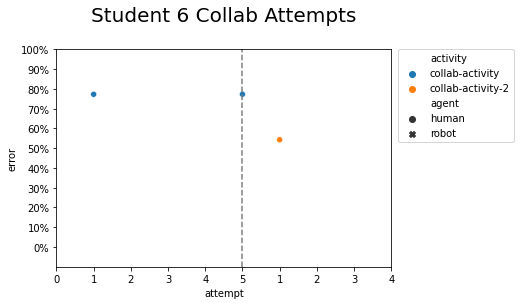

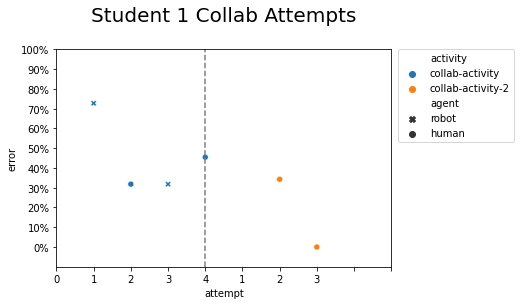

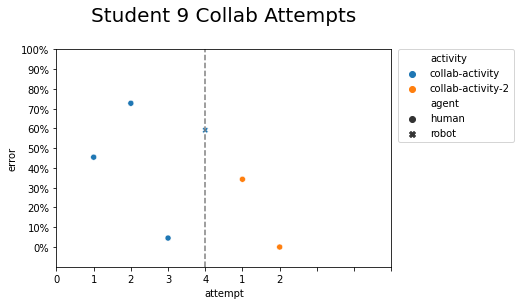

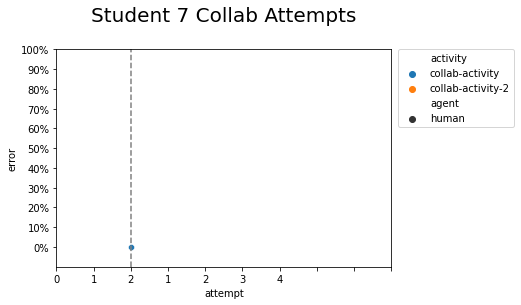

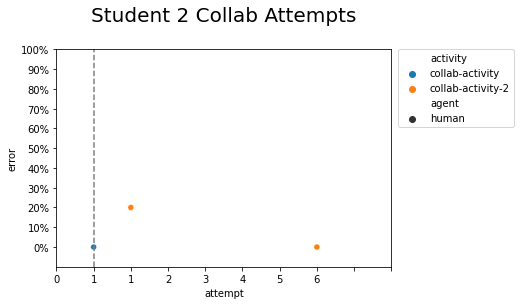

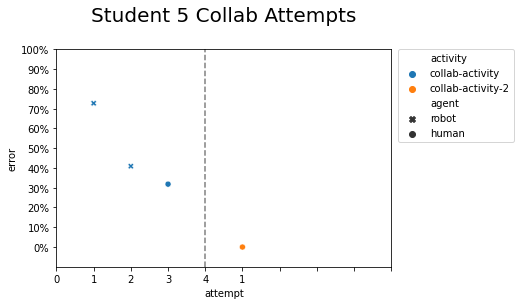

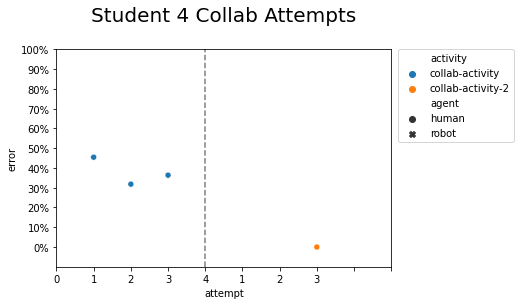

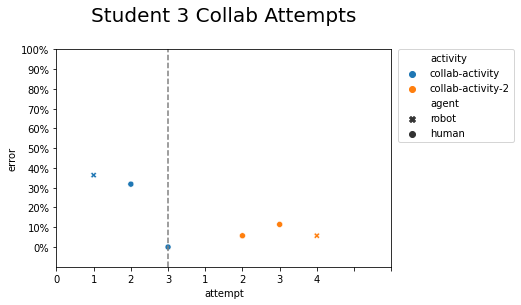

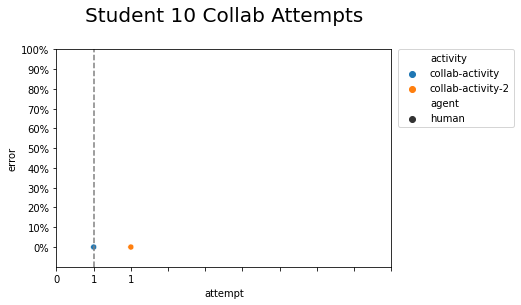

In [16]:
for student, df in collab_attempts.items():
    plt.figure()
    markers = {"human": "o", "robot": "X"}
    sns.scatterplot(data=df, x="attempt", y="error",
                    hue="activity", style="agent",markers=markers)
    plt.ylim(-0.1, 1)

    yticks = [-0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1]
    plt.yticks(yticks[1:-1], [str(round(i*100)) + '%' for i in yticks[1:-1]])

    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    title = 'Student ' + str(int(df['student'][0])) + ' Collab Attempts\n'
    plt.title(title, loc='center', fontsize=20)

    # vertical line to divide plot by collaborative activity
    x = df.index[df['activity'] == 'collab-activity-2'].tolist()
    plt.axvline(x[0], 0, 1, ls='--', c='grey')

    # custom xticks for student attempts during each collab activity
    t = custom_xticks[student]
    if t[0] != 0:
        t.insert(0, 0)

    plt.xticks(np.arange(0, 10, 1.0), labels=t)

## Computing slope and p-value of linear regressions analysis.
Compare error progression among attempts in a collaborative activity by
computing the slope and p-value of a simple linear regression analysis 

### Reformatting dataframe.

In [17]:
collab_attempts


{6:             activity  agent     error  student  attempt
 0    collab-activity  human  0.772727        6        1
 1    collab-activity  robot       NaN        6        2
 2    collab-activity  robot       NaN        6        3
 3    collab-activity  robot       NaN        6        4
 4    collab-activity  human  0.772727        6        5
 5  collab-activity-2  human  0.542857        6        6
 6  collab-activity-2  human       NaN        6        7
 7  collab-activity-2  human       NaN        6        8
 8  collab-activity-2  human       NaN        6        9,
 1:             activity  agent     error  student  attempt
 0    collab-activity  robot  0.727273        1        1
 1    collab-activity  human  0.318182        1        2
 2    collab-activity  robot  0.318182        1        3
 3    collab-activity  human  0.454545        1        4
 4  collab-activity-2  robot       NaN        1        5
 5  collab-activity-2  human  0.342857        1        6
 6  collab-activity-2  h

In [18]:
linregress_df = pd.DataFrame()

stud = []
collab_p = []
collab_s = []
collab2_p = []
collab2_s = []

for student,df in collab_attempts.items():
    if student != 7:
        df.dropna(inplace=True)
#         df.fillna(0, inplace=True) #should the na's be replaced with the maximum error or not counted at all
        c1 = list(df.loc[df['activity'] == 'collab-activity']['error'])
        ac1 = list(df.loc[df['activity'] == 'collab-activity']['attempt'])
        c2 = list(df.loc[df['activity'] == 'collab-activity-2']['error'])
        ac2 = list(df.loc[df['activity'] == 'collab-activity-2']['attempt'])
        error = list(df['error'])
        attempt = list(df['attempt'])
        print(c1,ac1,c2,ac2)

        slope1, intercept1, r_value1, p_value1, std_err1 = stats.linregress(ac1,c1)
        slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(ac2,c2)
        slope3, intercept3, r_value3, p_value3, std_err3 = stats.linregress(attempt,error)
        print('Stud.',student, '| len c1:', len(c1), 'len c2:', len(c2))
        print('\tcollab-activity:','p_value1:', p_value1,'slope1:',slope1)
        print('\tcollab-activity-2:','p_value2:', p_value2,'slope2:',slope2)
        print('\tcollab-activity-3:','p_value3:', p_value3,'slope3:',slope3)
        
        stud.append(student)
        collab_p.append(p_value1)
        collab_s.append(slope1)
        collab2_p.append(p_value2)
        collab2_s.append(slope2)

[0.7727272727272727, 0.7727272727272727] [1, 5] [0.5428571428571428] [6]
Stud. 6 | len c1: 2 len c2: 1
	collab-activity: p_value1: 1.0 slope1: 0.0
	collab-activity-2: p_value2: nan slope2: nan
	collab-activity-3: p_value3: 0.54562894834299 slope3: -0.032838589981447126
[0.7272727272727273, 0.3181818181818182, 0.3181818181818182, 0.45454545454545453] [1, 2, 3, 4] [0.34285714285714286, 0.0] [6, 7]
Stud. 1 | len c1: 4 len c2: 2
	collab-activity: p_value1: 0.4522774424948337 slope1: -0.08181818181818183
	collab-activity-2: p_value2: 0.0 slope2: -0.34285714285714286
	collab-activity-3: p_value3: 0.0754353654808593 slope3: -0.0779059449866903
[0.45454545454545453, 0.7272727272727273, 0.045454545454545456, 0.5909090909090909] [1, 2, 3, 4] [0.34285714285714286, 0.0] [5, 6]
Stud. 9 | len c1: 4 len c2: 2
	collab-activity: p_value1: 0.8804771390665607 slope1: -0.02727272727272726
	collab-activity-2: p_value2: 0.0 slope2: -0.34285714285714286
	collab-activity-3: p_value3: 0.28213363281190423 slope

/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/venv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/venv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:174: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/venv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:176: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/venv/lib/python3.7/site-packages/scipy/stats/_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/venv/li

In [19]:
linregress_df = pd.DataFrame()

linregress_df['student'] = stud
linregress_df['collab_pval'] = collab_p 
linregress_df['collab_slope'] = collab_s
linregress_df['collab2_pval'] = collab2_p
linregress_df['collab2_slope'] = collab2_s

linregress_df

,student,collab_pval,collab_slope,collab2_pval,collab2_slope
0,6,1.000000,0.000000,NaN,NaN
1,1,0.452277,-0.081818,0.0,-0.342857
2,9,0.880477,-0.027273,0.0,-0.342857
3,2,NaN,NaN,0.0,-0.040000
4,5,0.197596,-0.204545,NaN,NaN
5,4,0.545629,-0.045455,NaN,NaN
6,3,0.260147,-0.181818,1.0,0.000000
7,10,NaN,NaN,NaN,NaN


In [20]:
significant = 0
for index,row in linregress_df.iterrows():
    if row['collab_pval'] < 0.05:
        significant +=1
percentage = (significant/len(linregress_df))*100
percentage

0.0

### Computing Spearman correlation.

In [21]:
for student,df in collab_attempts.items():
    if student != 7:
        df.dropna(inplace=True)
#         df.fillna(0, inplace=True) #should the na's be replaced with the maximum error or not counted at all
        c1 = list(df.loc[df['activity'] == 'collab-activity']['error'])
        ac1 = list(df.loc[df['activity'] == 'collab-activity']['attempt'])
        c2 = list(df.loc[df['activity'] == 'collab-activity-2']['error'])
        ac2 = list(df.loc[df['activity'] == 'collab-activity-2']['attempt'])
        error = list(df['error'])
        attempt = list(df['attempt'])
#         print(c1,ac1,c2,ac2)

        rho1, pval1 = stats.spearmanr(c1, ac1, nan_policy='omit')
        rho2, pval2 = stats.spearmanr(c2, ac2, nan_policy='omit')
        print('Stud.',student, '| len c1:', len(c1), 'len c2:', len(c2))
        print('\tcollab-activity:','rho1:', rho1,'pval1:',pval1)
        print('\tcollab-activity-2:','rho2:', rho2,'pval2:',pval2)


Stud. 6 | len c1: 2 len c2: 1
	collab-activity: rho1: nan pval1: nan
	collab-activity-2: rho2: nan pval2: nan
Stud.

/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/venv/lib/python3.7/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


 1 | len c1: 4 len c2: 2
	collab-activity: rho1: -0.316227766016838 pval1: 0.683772233983162
	collab-activity-2: rho2: -0.9999999999999999 pval2: nan
Stud. 9 | len c1: 4 len c2: 2
	collab-activity: rho1: 0.0 pval1: 1.0
	collab-activity-2: rho2: -0.9999999999999999 pval2: nan
Stud. 2 | len c1: 1 len c2: 2
	collab-activity: rho1: nan pval1: nan
	collab-activity-2: rho2: -0.9999999999999999 pval2: nan
Stud. 5 | len c1: 3 len c2: 1
	collab-activity: rho1: -1.0 pval1: 0.0
	collab-activity-2: rho2: nan pval2: nan
Stud. 4 | len c1: 3 len c2: 1
	collab-activity: rho1: -0.5 pval1: 0.6666666666666667
	collab-activity-2: rho2: nan pval2: nan
Stud. 3 | len c1: 3 len c2: 3
	collab-activity: rho1: -1.0 pval1: 0.0
	collab-activity-2: rho2: 0.0 pval2: 1.0
Stud. 10 | len c1: 1 len c2: 1
	collab-activity: rho1: nan pval1: nan
	collab-activity-2: rho2: nan pval2: nan


# 3 Error over entire experiment evolution.

In [22]:
collab_best_copy = collab_best.copy()
# make dataframe for entire experiment for each student, using the best submissions of the collaborative activities
evolution_dfs = {}

for student,df in all_tables.items():
    print('student',student)
    # removing collaborative activity rows
    df = df[df['header.frame_id'] != "collab-activity"]
    df = df[df['header.frame_id'] != "collab-activity-2"]
    
    df.rename(columns={"header.frame_id": "activity",
                     "action.agent_name": "agent", "normalized_error": "error"}, inplace=True)
    
    # searching collab_best for collaborative activities of the student
    for index, row in collab_best_copy.iterrows():
        #if the student number of the best row matches the student
        if int(row['student']) == int(student):
            #then add the row of that student to the df
            df = df.append(row)
    
    # removing excess columns
    df.drop(columns=['world_state', 'is_submission', 'is_mst', 'cost', 'mst_cost', 'spanning', 'action'
                            ], inplace=True)
    
    # setting student column values
    df[['student']] = int(df.iloc[[-1][0]]['student'])
    
    #reset index
    df.reset_index(drop=True, inplace=True)
    
    #reorganizing dataframe so that collab activities are between tests
    posttests = df.loc[df['activity'].isin(['posttest-1','posttest-2','posttest-3','posttest-4','posttest-5'])]
    df = df.drop([5,6,7,8,9])
    df = df.append(posttests)
    df.reset_index(drop=True, inplace=True)
    
    #adding to dictionary
    evolution_dfs[student] = df
    display(df)
evolution_dfs


student 6


,activity,agent,error,student
0,pretest-1,human,0.266667,6
1,pretest-2,human,0.533333,6
2,pretest-3,human,0.238095,6
3,pretest-4,human,0.244444,6
4,pretest-5,human,0.266667,6
5,collab-activity,NaN,0.772727,6
6,collab-activity-2,NaN,0.542857,6
7,posttest-1,human,NaN,6
8,posttest-2,human,0.266667,6
9,posttest-3,human,0.238095,6


student 1


,activity,agent,error,student
0,pretest-1,human,0.533333,1
1,pretest-2,human,0.266667,1
2,pretest-3,human,0.047619,1
3,pretest-4,human,0.000000,1
4,pretest-5,human,0.000000,1
5,collab-activity,NaN,0.318182,1
6,collab-activity-2,NaN,0.000000,1
7,posttest-1,human,0.000000,1
8,posttest-2,human,0.000000,1
9,posttest-3,human,0.000000,1


student 9


,activity,agent,error,student
0,pretest-1,human,0.200000,9
1,pretest-2,human,1.600000,9
2,pretest-3,human,1.428571,9
3,pretest-4,human,1.200000,9
4,pretest-5,human,0.200000,9
5,collab-activity,NaN,0.045455,9
6,collab-activity-2,NaN,0.000000,9
7,posttest-1,human,0.133333,9
8,posttest-2,human,0.200000,9
9,posttest-3,human,0.095238,9


student 7


,activity,agent,error,student
0,pretest-1,human,0.2,7
1,pretest-2,human,0.0,7
2,pretest-3,human,NaN,7
3,pretest-4,human,NaN,7
4,pretest-5,human,NaN,7
5,collab-activity,NaN,0.0,7
6,collab-activity-2,NaN,NaN,7
7,posttest-1,human,NaN,7
8,posttest-2,human,NaN,7
9,posttest-3,human,NaN,7


student 2


,activity,agent,error,student
0,pretest-1,human,NaN,2
1,pretest-2,human,0.600000,2
2,pretest-3,human,0.285714,2
3,pretest-4,human,0.200000,2
4,pretest-5,human,0.466667,2
5,collab-activity,NaN,0.000000,2
6,collab-activity-2,NaN,0.000000,2
7,posttest-1,human,0.000000,2
8,posttest-2,human,0.000000,2
9,posttest-3,human,0.047619,2


student 5


,activity,agent,error,student
0,pretest-1,human,0.466667,5
1,pretest-2,human,0.266667,5
2,pretest-3,human,0.190476,5
3,pretest-4,human,0.377778,5
4,pretest-5,human,0.200000,5
5,collab-activity,NaN,0.318182,5
6,collab-activity-2,NaN,0.000000,5
7,posttest-1,human,0.266667,5
8,posttest-2,human,NaN,5
9,posttest-3,human,0.190476,5


student 4


,activity,agent,error,student
0,pretest-1,human,NaN,4
1,pretest-2,human,1.266667,4
2,pretest-3,human,0.238095,4
3,pretest-4,human,0.111111,4
4,pretest-5,human,0.333333,4
5,collab-activity,NaN,0.318182,4
6,collab-activity-2,NaN,0.000000,4
7,posttest-1,human,0.200000,4
8,posttest-2,human,0.400000,4
9,posttest-3,human,0.333333,4


student 3


,activity,agent,error,student
0,pretest-1,human,0.066667,3
1,pretest-2,human,0.066667,3
2,pretest-3,human,0.047619,3
3,pretest-4,human,0.022222,3
4,pretest-5,human,0.000000,3
5,collab-activity,NaN,0.000000,3
6,collab-activity-2,NaN,0.057143,3
7,posttest-1,human,0.000000,3
8,posttest-2,human,0.000000,3
9,posttest-3,human,0.000000,3


student 10


,activity,agent,error,student
0,pretest-1,human,0.066667,10
1,pretest-2,human,0.000000,10
2,pretest-3,human,0.000000,10
3,pretest-4,human,0.000000,10
4,pretest-5,human,0.000000,10
5,collab-activity,NaN,0.000000,10
6,collab-activity-2,NaN,0.000000,10
7,posttest-1,human,0.000000,10
8,posttest-2,human,0.000000,10
9,posttest-3,human,0.047619,10


{6:              activity  agent     error  student
 0           pretest-1  human  0.266667        6
 1           pretest-2  human  0.533333        6
 2           pretest-3  human  0.238095        6
 3           pretest-4  human  0.244444        6
 4           pretest-5  human  0.266667        6
 5     collab-activity    NaN  0.772727        6
 6   collab-activity-2    NaN  0.542857        6
 7          posttest-1  human       NaN        6
 8          posttest-2  human  0.266667        6
 9          posttest-3  human  0.238095        6
 10         posttest-4  human  0.177778        6
 11         posttest-5  human  0.066667        6,
 1:              activity  agent     error  student
 0           pretest-1  human  0.533333        1
 1           pretest-2  human  0.266667        1
 2           pretest-3  human  0.047619        1
 3           pretest-4  human  0.000000        1
 4           pretest-5  human  0.000000        1
 5     collab-activity    NaN  0.318182        1
 6   collab-a

# Visualizing student complete evolution.

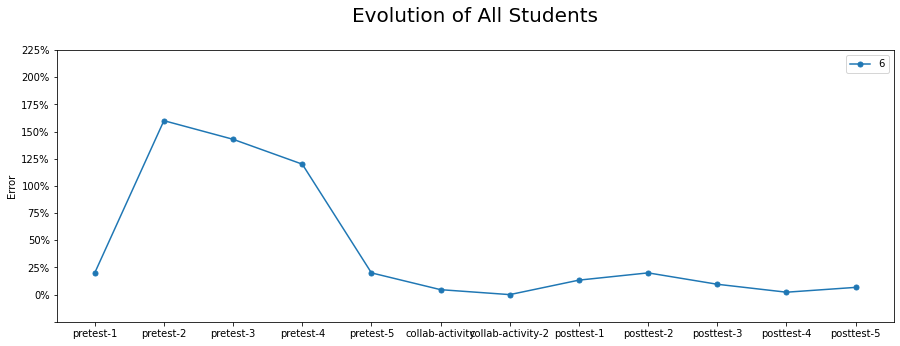

In [23]:
test = evolution_dfs[9]

# helper function to graph each student dataframe on same plot, takes dataframe as input
def generate_visualization(df):
    temp = df

    # visualization for error evolution over the best submission in each collaborative activity
    students = [1, 2, 3, 4, 5, 6, 7, 9, 10]
    separation = 0.01

    # graphing the pretest versus posttest is_spanning scores
    plt.plot(temp.activity, temp.error, marker='o', markersize=5)
    fig = plt.gcf()
    fig.set_size_inches(15, 5)
    
    plt.ylabel('Error')
    title = "Evolution of All Students\n"
    plt.title(title, loc='center', fontsize=20)

    leg = plt.legend(evolution_dfs.keys(), loc='upper right', frameon=True)

    # ensure that y-axis labelling is proportional to maximum possible error 
    plt.ylim(-0.1, max_error[1])
    locs,labels = plt.yticks()
    labels = [str(round(i*100)) + '%' for i in locs]
    labels[0] = ''
    plt.yticks(locs,labels)

generate_visualization(test)

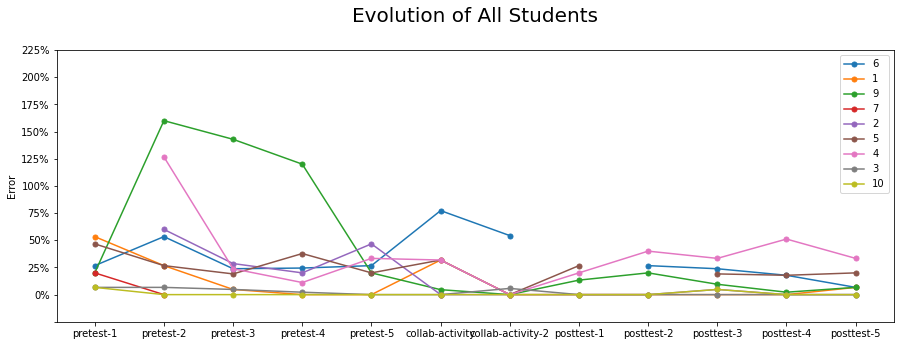

In [24]:
for student, df in evolution_dfs.items():
    generate_visualization(df)


# Find task intervals for all logs from their tables.
- slicers: put markers or checkpoints that point to the start and end of an activity
    - intervals dict for each student with start and end timestamps tuples
    - confirm the checkpoints: delete overlap and check contiguity and continuity
    
- One way to have a simpler check is to count number of transitions into that activity and move on if it is one, handle the case if it is more than one (for the case of going into and out from that activity).


In [25]:
# return the task interval times and handle cleaning from discontinuous log errors
def find_task_intervals(df, task):
    df = df.copy()
    df = df.loc[df['header.frame_id'] == task]
    start = df.iloc[0]['Time']
    end = df.iloc[-1]['Time']
    return start, end

headers = ['pretest-1', 'pretest-2', 'pretest-3', 'pretest-4', 'pretest-5', 'collab-activity',
           'collab-activity-2', 'posttest-1', 'posttest-2', 'posttest-3', 'posttest-4', 'posttest-5']

# log the start and end times of every task for every student
student_intervals = {}
for student, table in processed_tables.items():
    intervals = {}
    for i in headers:
        start, end = find_task_intervals(table.copy(), i)
        intervals[i] = (start, end)
    student_intervals[student] = intervals
display(student_intervals)


{6: {'pretest-1': (107.78392219543456, 167.10686135292053),
  'pretest-2': (195.68815732002255, 230.0998957157135),
  'pretest-3': (251.1525661945343, 289.6736686229706),
  'pretest-4': (314.58395075798035, 360.7600588798523),
  'pretest-5': (380.4511823654175, 423.1908950805664),
  'collab-activity': (727.2702190876007, 2235.430909395218),
  'collab-activity-2': (2282.949033498764, 3404.7349185943604),
  'posttest-1': (3639.168105602264, 3670.641201496124),
  'posttest-2': (3684.864453077316, 3714.0895581245422),
  'posttest-3': (3726.333530187607, 3757.8723559379578),
  'posttest-4': (3772.7371962070474, 3805.1794571876526),
  'posttest-5': (3815.6659920215607, 3868.023068666458)},
 1: {'pretest-1': (96.4143397808075, 161.27743887901306),
  'pretest-2': (184.98478150367737, 251.00974297523496),
  'pretest-3': (273.7148389816284, 319.2249743938446),
  'pretest-4': (341.8985347747803, 386.28241419792175),
  'pretest-5': (404.6526141166687, 435.3684105873108),
  'collab-activity': (491.

In [26]:
def gantt_chart(df):
    
    # Declaring a figure "gnt" 
    fig, gnt = plt.subplots() 

    # Setting Y-axis limits 
    gnt.set_ylim(0, 100) 

    # Setting X-axis limits 
    gnt.set_xlim(0, 4000) 

    # Setting labels for x-axis and y-axis 
    gnt.set_xlabel('seconds since start') 
    gnt.set_ylabel('Activity') 

    # Setting ticks on y-axis 
    gnt.set_yticks([15, 25, 35, 45, 55, 65, 75, 85, 95,105,115,125]) 
    # Labelling tickes of y-axis 
    gnt.set_yticklabels(['pretest-1', 'pretest-2', 'pretest-3', 'pretest-4', 'pretest-5', 'collab-activity', 'collab-activity-2', 'posttest-1', 'posttest-2', 'posttest-3', 'posttest-4', 'posttest-5']) 

    # Setting graph attribute 
    gnt.grid(True) 

    # Declaring all the bars for each activity 
    for i in range(len(df)):
        gnt.broken_barh([(df.loc[i,'start'], df.loc[i,'duration'])], ((i+1)*10, 9), facecolors =('tab:red')) 

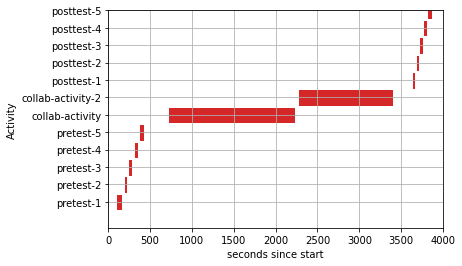

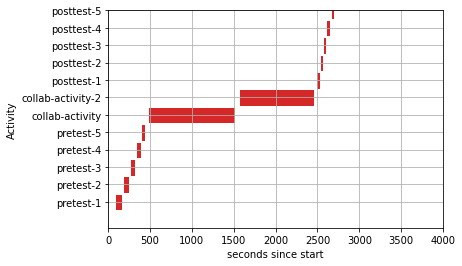

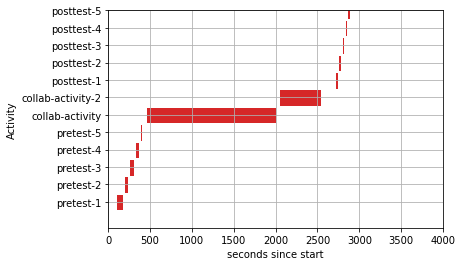

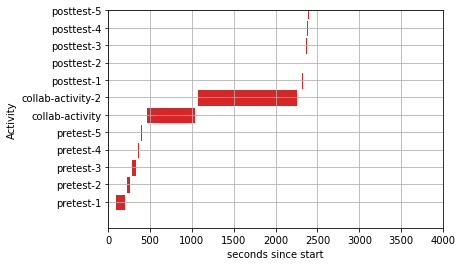

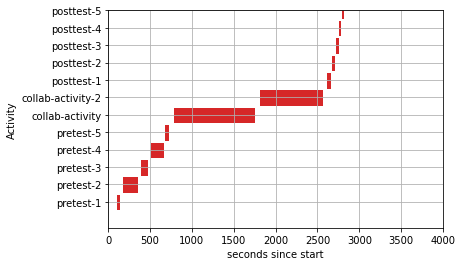

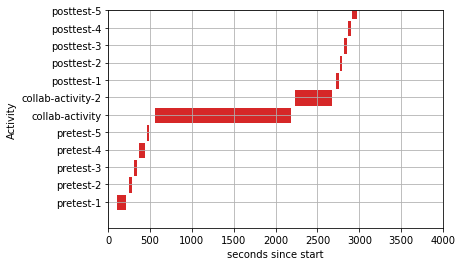

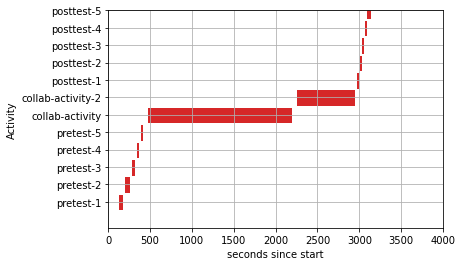

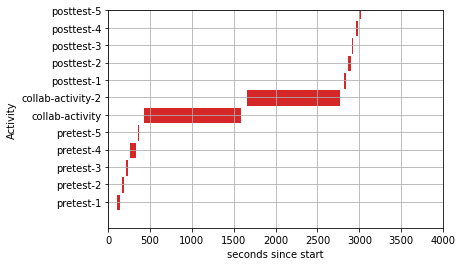

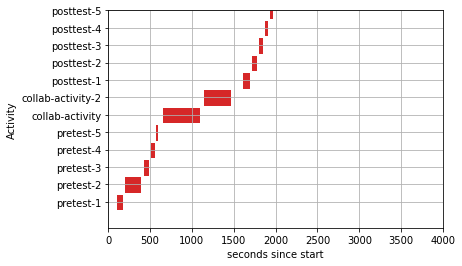

In [27]:
time_df = pd.DataFrame()

for student,values in student_intervals.items():
    #time_df = pd.DataFrame.from_dict(values)
    time_df['activity'] = values.keys()
    times = values.values()
    start = []
    end = []
    duration = []
    for i in times:
        s,e = i
        start.append(s)
        end.append(e) 
        duration.append(e-s)
    time_df['start'] = start
#     time_df['end'] = end
    time_df['duration'] = duration
#     display(time_df)
    
    gantt_chart(time_df)

In [28]:
#compute averages on start end pairs and slices averages

# Evolution across human actions in a collaborative activity.

S = optimal suggestions by the human, 
A = optimal agreements by the human, 
D = optimal disagreements by the human


In [29]:
action_type_dict = {
    'TYPE_SUGGEST_PICK': 0,
    'TYPE_PICK': 1,
    'TYPE_UNPICK': 2,
    'TYPE_SUBMIT': 3,
    'TYPE_SUGGEST_SUBMIT': 4,
    'TYPE_CLEAR_SUGGEST_SUBMIT': 5,
    'TYPE_AGREE': 6,
    'TYPE_DISAGREE': 7,
    'TYPE_CLEAR': 8,
    'TYPE_GUESS': 9}

In [30]:
pd.options.display.max_rows = None
a = processed_tables[6]

a = a.loc[a['action.agent_name'] == 'human']
a = a.loc[a['action.type'] == 7]
a.iloc[0]['Time']

867.5732035636902

### Assembling action indices and time intervals.

In [31]:
lens = {}
start = {}
lens_time = {}
start_time = {}

#logging length and starting indices and times
for student,df in processed_tables.items():
    collabs = df.loc[df['header.frame_id'].isin(
    ['collab-activity', 'collab-activity-2'])].copy()
    lens[student] = len(collabs)
    print(collabs.iloc[0]['Time'],collabs.iloc[-1]['Time'])
    start[student] = collabs.index[0]
    start_time[student] = collabs.iloc[0]['Time']
    lens_time[student] = float(collabs.iloc[-1]['Time']) - float(collabs.iloc[0]['Time'])
lens_time


727.2702190876007 3404.7349185943604
491.86025953292847 2461.4668402671814
466.9142258167267 2543.180943965912
465.61409425735474 2257.2904303073883
783.9192252159119 2569.8164587020874
555.0043919086456 2673.9500527381897
477.0381371974945 2947.4677414894104
427.7972276210785 2774.173730134964
658.1744134426117 1466.5949020385742


{6: 2677.4646995067596,
 1: 1969.606580734253,
 9: 2076.266718149185,
 7: 1791.6763360500336,
 2: 1785.8972334861755,
 5: 2118.945660829544,
 4: 2470.429604291916,
 3: 2346.3765025138855,
 10: 808.4204885959625}

### Checking if an action is optimal.

In [32]:
def is_opt(df,action,student,progress_by):
    is_opt = []
    #slicing only the human suggestions
    df = df.loc[df['action.agent_name'] == 'human']
    df = df.loc[df['action.type'] == action_type_dict[action]]
    
    for index,row in df.iterrows():
        #getting network state
        #n = df.iloc[0]['world_state']
        n = row['world_state']
        # print(n.edges)

        #getting mst graph of the problem
        g = n.get_mst()
        # help(g)

        #for collab activities if there are two mst solutions
        #add the edge to the mst and then check if the edge is on the superimposed network
        g_2 = g.copy()
        g_2.add_edge(2, 8, cost=3)
        g_2.add_edge(9, 4, cost=3)
        g_2.remove_edge(1, 9)

#         print(g_2.number_of_edges())
        #b = df.iloc[0]['action']
        if action_type_dict[action] == 0:
            b = row['action']
            u,v = b.edge
            is_opt.append(g.has_edge(u,v)) #then it is optimal
        if action_type_dict[action] == 6 or action_type_dict[action] == 7:
            u = row['state.suggested.u']
            v = row['state.suggested.v']
            is_opt.append(g.has_edge(u,v)) #then it is optimal
    #is optimal true/false column
    
    if progress_by == 'action':
        shift = start[student]
        shift_elements = list(df.index)
        name = 'new_index'
    if progress_by == 'time':
        shift = start_time[student]
        shift_elements = list(df['Time'])
        name = 'new_time'
        
    if action_type_dict[action] == 0:
        df['opt_suggestion'] = is_opt
        
        #shifting index so that index 0 is where the collaborative activities begin
        df[name] = [x - shift for x in shift_elements]
        if progress_by == 'action':
            df = df.set_index('new_index')
        return(is_opt,df)
    if action_type_dict[action] == 6:   
        df['opt_agree'] = is_opt
        df[name] = [x - shift for x in shift_elements]
        if progress_by == 'action':
            df = df.set_index('new_index')
        return(is_opt,df)
    if action_type_dict[action] == 7:   
        df['opt_disagree'] = is_opt
        df[name] = [x - shift for x in shift_elements]
        if progress_by == 'action':
            df = df.set_index('new_index')
        return(is_opt,df)

is_opt(processed_tables[6],'TYPE_SUGGEST_PICK',6, 'time')
is_opt(processed_tables[6],'TYPE_AGREE',6,'time')
is_opt(processed_tables[6],'TYPE_DISAGREE',6, 'action')

([False,
  False,
  False,
  True,
  False,
  True,
  True,
  True,
  False,
  False,
  True,
  False,
  False,
  True,
  False,
  False,
  False,
  False],
                   Time  header.seq    header.frame_id  \
 new_index                                               
 8           867.573204           6    collab-activity   
 18         1040.006722          16    collab-activity   
 22         1102.601774          20    collab-activity   
 26         1156.988669          24    collab-activity   
 42         1379.755905          40    collab-activity   
 46         1446.045852          44    collab-activity   
 50         1496.386504          48    collab-activity   
 87         2040.101148          85    collab-activity   
 99         2189.657907          97    collab-activity   
 140        2742.909367         138  collab-activity-2   
 144        2795.839774         142  collab-activity-2   
 152        2883.797944         150  collab-activity-2   
 156        2929.582781        

## 1 Evolution over actions.

### Computing quartiles and medians by action.

In [33]:
sad_dict = {}

for student,df in processed_tables.items():
    t = {}
    S,sdf = is_opt(df,'TYPE_SUGGEST_PICK',student,'action')
    A,adf = is_opt(df,'TYPE_AGREE',student,'action')
    D,ddf = is_opt(df,'TYPE_DISAGREE',student,'action')

    #loop through list to normalize by the num of the collab activities by action
    t['S'] = [x / lens[student] for x in list(sdf.index)] 
    t['A'] = [x / lens[student] for x in list(adf.index)] 
    t['D'] = [x / lens[student] for x in list(ddf.index)] 
    sad_dict[student] = t
    
#     display(sdf)
sad_dict


{6: {'S': [0.02617801047120419,
   0.04712041884816754,
   0.06282722513089005,
   0.07853403141361257,
   0.09947643979057591,
   0.12041884816753927,
   0.14136125654450263,
   0.16230366492146597,
   0.18324607329842932,
   0.20418848167539266,
   0.23036649214659685,
   0.24607329842931938,
   0.2670157068062827,
   0.29842931937172773,
   0.3298429319371728,
   0.34554973821989526,
   0.3769633507853403,
   0.39790575916230364,
   0.418848167539267,
   0.4397905759162304,
   0.4607329842931937,
   0.4816753926701571,
   0.5026178010471204,
   0.5235602094240838,
   0.5549738219895288,
   0.5759162303664922,
   0.5968586387434555,
   0.612565445026178,
   0.6335078534031413,
   0.6544502617801047,
   0.6701570680628273,
   0.6963350785340314,
   0.7172774869109948,
   0.7382198952879581,
   0.7591623036649214,
   0.7801047120418848,
   0.8010471204188482,
   0.8219895287958116,
   0.8481675392670157,
   0.8691099476439791,
   0.8900523560209425,
   0.9057591623036649,
   0.92670157

### Calculating descriptive statistics for action optimality.

- all optimal/all actions
- s/all actions
- a/all actions
- d/all actions


In [34]:
for student,sad in sad_dict.items():
    p_all = round(((len(sad['S'])+len(sad['A'])+len(sad['D'])) / lens[student])*100,2)
    p_s = round((len(sad['S']) / lens[student])*100,2)
    p_a = round((len(sad['A']) / lens[student])*100,2)
    p_d = round((len(sad['D']) / lens[student])*100,2)
    print('Student',student,'S:',p_s,'A:',p_a,'D:',p_d,'\t|', str(p_all)+'% optimal actions')
    

Student 6 S: 24.08 A: 15.18 D: 9.42 	| 48.69% optimal actions
Student 1 S: 24.62 A: 20.1 D: 5.03 	| 49.75% optimal actions
Student 9 S: 24.86 A: 20.0 D: 6.49 	| 51.35% optimal actions
Student 7 S: 23.88 A: 11.19 D: 14.18 	| 49.25% optimal actions
Student 2 S: 23.28 A: 14.66 D: 11.21 	| 49.14% optimal actions
Student 5 S: 24.57 A: 10.29 D: 14.86 	| 49.71% optimal actions
Student 4 S: 24.76 A: 15.24 D: 10.0 	| 50.0% optimal actions
Student 3 S: 25.56 A: 18.89 D: 7.22 	| 51.67% optimal actions
Student 10 S: 23.33 A: 10.0 D: 16.67 	| 50.0% optimal actions


### Computing medians through progress by action.

In [35]:
average_medians = []
average_s = []
average_a = []
average_d = []
for student,sad in sad_dict.items():
    actions = ['S','A','D']
    medians = []
    for action,a in sad.items():
        print("Action",action)
        print("Q1 quantile of Student",student,"suggestions: ", np.quantile(sad[action], .25, interpolation='midpoint'))
        print("Q2 quantile of Student",student,"suggestions: ", np.quantile(sad[action], .50, interpolation='midpoint'))
        print("Q3 quantile of Student",student,"suggestions: ", np.quantile(sad[action], .75, interpolation='midpoint'))
        print("Q4 quantile of Student",student,"suggestions: ", np.quantile(sad[action], 1.0, interpolation='midpoint'))
        print("Median:",np.median(sad[action]),'\n')
        medians.append(np.median(sad[action]))
        
    average_s.append(np.median(sad['S']))
    average_a.append(np.median(sad['A']))
    average_d.append(np.median(sad['D']))

    avg_median = sum(medians) / len(medians)
    print('Average median:',avg_median,'\n\n')
    average_medians.append(avg_median)


total_avg = sum(average_medians) / len(average_medians)
total_s = sum(average_s) / len(average_s)
total_a = sum(average_a) / len(average_a)
total_d = sum(average_d) / len(average_d)

print('Average S medians:',total_s)
print('Average A medians:',total_a)
print('Average D medians:',total_d)
print('Average of all medians:', total_avg)


Action S
Q1 quantile of Student 6 suggestions:  0.25654450261780104
Q2 quantile of Student 6 suggestions:  0.5130890052356021
Q3 quantile of Student 6 suggestions:  0.7486910994764397
Q4 quantile of Student 6 suggestions:  0.9947643979057592
Median: 0.5130890052356021 

Action A
Q1 quantile of Student 6 suggestions:  0.19895287958115182
Q2 quantile of Student 6 suggestions:  0.43455497382198954
Q3 quantile of Student 6 suggestions:  0.6282722513089005
Q4 quantile of Student 6 suggestions:  0.9895287958115183
Median: 0.43455497382198954 

Action D
Q1 quantile of Student 6 suggestions:  0.23036649214659688
Q2 quantile of Student 6 suggestions:  0.6256544502617801
Q3 quantile of Student 6 suggestions:  0.8272251308900523
Q4 quantile of Student 6 suggestions:  0.9424083769633508
Median: 0.6256544502617801 

Average median: 0.524432809773124 


Action S
Q1 quantile of Student 1 suggestions:  0.25125628140703515
Q2 quantile of Student 1 suggestions:  0.507537688442211
Q3 quantile of Student 

/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/venv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/venv/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/ven

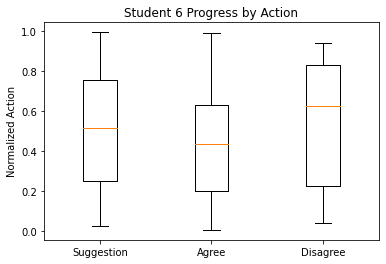

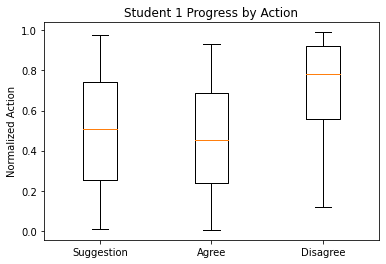

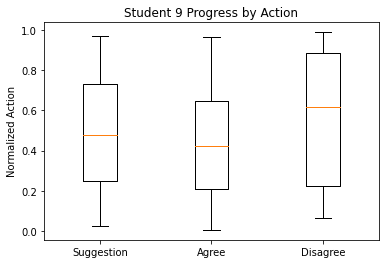

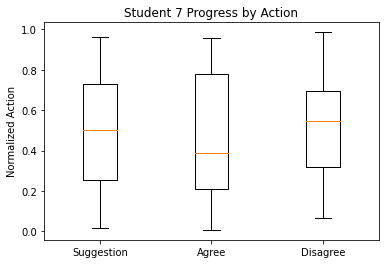

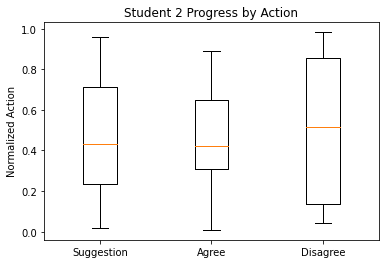

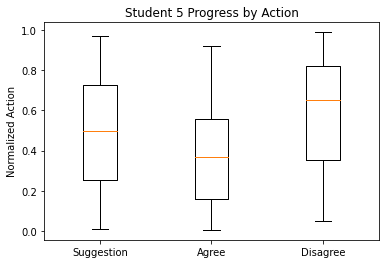

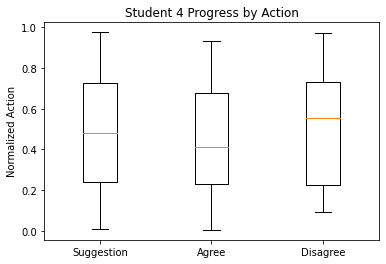

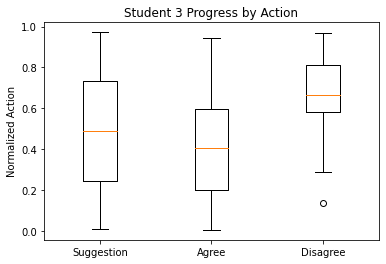

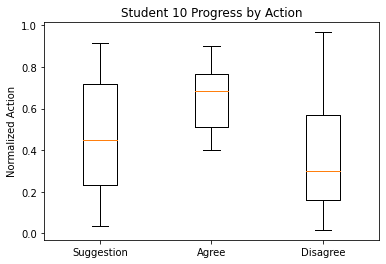

In [36]:
for student,sad in sad_dict.items():
    fig, ax = plt.subplots()
    title = 'Student '+str(student) + ' Progress by Action'
    ax.set_title(title)
    ax.boxplot([sad['S'],sad['A'],sad['D']])
    ax.set_xticklabels(['Suggestion','Agree','Disagree'])
    ax.set_ylabel('Normalized Action')

## 2 Evolution over time.

### Computing quartiles and medians by time.

In [37]:
sad_dict_time = {}

for student,df in processed_tables.items():
    t = {}
    S,sdf = is_opt(df,'TYPE_SUGGEST_PICK',student,'time')
    A,adf = is_opt(df,'TYPE_AGREE',student,'time')
    D,ddf = is_opt(df,'TYPE_DISAGREE',student,'time')
#     print(S,'\n',A,'\n',D)
    
    #loop through list to normalize by the num of the collab activities by time
    t['S'] = [x / lens_time[student] for x in list(sdf['new_time'])] 
    t['A'] = [x / lens_time[student] for x in list(adf['new_time'])] 
    t['D'] = [x / lens_time[student] for x in list(ddf['new_time'])] 
    sad_dict_time[student] = t
    
sad_dict_time


{6: {'S': [0.038752498745470085,
   0.06686155714476809,
   0.08528720450635378,
   0.10412924296202265,
   0.1266551579359946,
   0.1469096216354485,
   0.16996570388516863,
   0.1958258073349836,
   0.21366284066189137,
   0.23156081662913294,
   0.2580612457594269,
   0.27330383169338257,
   0.29325153973400647,
   0.324462380593968,
   0.34742402673758926,
   0.3644596263034876,
   0.4155750966062626,
   0.43899446214583826,
   0.4577423689450327,
   0.4788272984687809,
   0.49622362168591233,
   0.5169054827919584,
   0.5337449292671758,
   0.5512515902284769,
   0.5900159824556891,
   0.6065077361510178,
   0.6244631991351443,
   0.6382433486985182,
   0.6568051798765945,
   0.6791012179310963,
   0.6941118447737288,
   0.7260848762922588,
   0.7408131038912404,
   0.7572663595353152,
   0.7769861054210997,
   0.7941279246915874,
   0.8107613536945836,
   0.8279051272663013,
   0.859125049789991,
   0.8761750253620764,
   0.8922832132249393,
   0.9096896400022274,
   0.9293663921

### Computing medians through progress by action.

In [38]:
average_medians_time = []
average_st = []
average_at = []
average_dt = []

for student,sad in sad_dict_time.items():
    actions = ['S','A','D']
    medians = []
    for action,a in sad.items():
        print("Action",action)
        print("Q1 quantile of Student",student,"suggestions: ", np.quantile(sad[action], .25, interpolation='midpoint'))
        print("Q2 quantile of Student",student,"suggestions: ", np.quantile(sad[action], .50, interpolation='midpoint'))
        print("Q3 quantile of Student",student,"suggestions: ", np.quantile(sad[action], .75, interpolation='midpoint'))
        print("Q4 quantile of Student",student,"suggestions: ", np.quantile(sad[action], 1.0, interpolation='midpoint'))
        print("Median:",np.median(sad[action]),'\n')
        medians.append(np.median(sad[action]))
        
    average_st.append(np.median(sad['S']))
    average_at.append(np.median(sad['A']))
    average_dt.append(np.median(sad['D']))

    avg_median = sum(medians) / len(medians)
    print('Average median:',avg_median,'\n\n')
    average_medians_time.append(avg_median)


total_avg_time = sum(average_medians_time) / len(average_medians_time)
total_st = sum(average_st) / len(average_st)
total_at = sum(average_at) / len(average_at)
total_dt = sum(average_dt) / len(average_dt)

print('Average S medians:',total_st)
print('Average A medians:',total_at)
print('Average D medians:',total_dt)
print('Average of all medians:', total_avg_time)


Action S
Q1 quantile of Student 6 suggestions:  0.2832776857136945
Q2 quantile of Student 6 suggestions:  0.5424982597478263
Q3 quantile of Student 6 suggestions:  0.7671262324782074
Q4 quantile of Student 6 suggestions:  1.0
Median: 0.5424982597478263 

Action A
Q1 quantile of Student 6 suggestions:  0.22554943377450415
Q2 quantile of Student 6 suggestions:  0.46992570195606403
Q3 quantile of Student 6 suggestions:  0.6512654585900707
Q4 quantile of Student 6 suggestions:  0.9944471008265338
Median: 0.46992570195606403 

Action D
Q1 quantile of Student 6 suggestions:  0.25607458400093935
Q2 quantile of Student 6 suggestions:  0.6495000357164644
Q3 quantile of Student 6 suggestions:  0.8313011675461706
Q4 quantile of Student 6 suggestions:  0.9407208296713274
Median: 0.6495000357164644 

Average median: 0.5539746658067849 


Action S
Q1 quantile of Student 1 suggestions:  0.26102016620789237
Q2 quantile of Student 1 suggestions:  0.4917622723265725
Q3 quantile of Student 1 suggestions:

### Plotting evolution over absolute time.

In [39]:

# plot the points in teh above pltos
# boxplots over time

# plot_establishment_absolute

### Plotting evolution over normalized time.

In [40]:
# plot_establishment_normalised

# Comparing first and last collab activity submissions.

In [41]:
fl_df = cdf_human.copy()

fldf = pd.DataFrame()

#formatting df so that only the first and last submissions remain
students = [1,2,3,4,5,6,7,9,10]
for i in students:
    stdf = fl_df.loc[fl_df['student'] == i]
    fl = pd.DataFrame()
    fl = fl.append(stdf.iloc[0])
    fl = fl.append(stdf.iloc[-1])
    fldf = fldf.append(fl,ignore_index=True)

    

fldf.drop(['agent'],axis=1,inplace=True)
fldf
        

,activity,error,student
0,collab-activity,0.318182,1.0
1,collab-activity-2,0.000000,1.0
2,collab-activity,0.000000,2.0
3,collab-activity-2,0.000000,2.0
4,collab-activity,0.318182,3.0
5,collab-activity-2,0.114286,3.0
6,collab-activity,0.454545,4.0
7,collab-activity-2,0.000000,4.0
8,collab-activity,0.318182,5.0
9,collab-activity-2,0.000000,5.0


### Visualizing first to last submission progress over time.

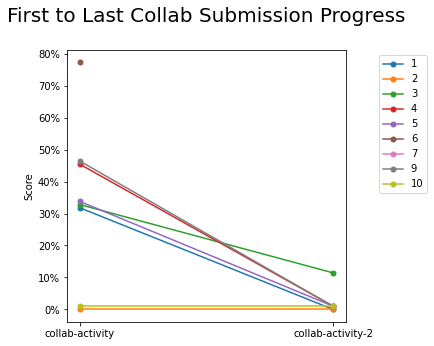

In [42]:
# visualization for error evolution over the best submission in each collaborative activity
students = [1, 2, 3, 4, 5, 6, 7, 9, 10]
separation = 0.01

# graphing the pretest versus posttest is_spanning scores
fig, ax = plt.subplots(1, figsize=(5, 5))

prelist = list()
postlist = list()
for i in students:
    temp = fldf[fldf['student'] == i]
    values = list(temp.error)
    #computing offset between overlapping lines
    p0 = values[0] + prelist.count(values[0])*separation
    p1 = values[1] + prelist.count(values[1])*separation
    prelist.append(values[0])
    postlist.append(values[1])
    #plotting
    plt.plot(temp.activity, [p0,p1], marker='o', markersize=5)
plt.ylabel('Score')
plt.title('First to Last Collab Submission Progress\n', loc='center', fontsize=20)

leg = plt.legend(students, loc='upper left', frameon=True)
# get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
# change to location of the legend
xOffset = 1.1
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform=ax.transAxes)

# set y axis ticks to percentages
yticks = plt.yticks()[0]
plt.yticks(yticks[1:-1], [str(round(i*100)) + '%' for i in yticks[1:-1]])
plt.show()


### Perform Wilcoxon signed-rank test

In [43]:
a = fldf.loc[fldf['activity'] == 'collab-activity']
collab_a = list(a['error'])

b = fldf.loc[fldf['activity'] == 'collab-activity-2']
collab_b = list(b['error'])


In [44]:
r = collab_a
o = collab_b 
w, p = wilcoxon(r, o, mode="exact")
# null hypotehsis says they are the same, p val less than threshold, reject hyp, conclude that post is larger than pretest
print('Exact:', 'W=', w, 'pvalue=', p)
a, b = wilcoxon(r, o, mode="exact", alternative="greater")
print('Greater:', 'W=', a, 'pvalue=', b)

Exact: W= 0.0 pvalue= 0.01755232593841686
Greater: W= 15.0 pvalue= 0.43264750216441666


/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/venv/lib/python3.7/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/alexandrachin/Desktop/data-justhink-spring21/analysis/venv/lib/python3.7/site-packages/scipy/stats/morestats.py:2981: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


### Compute effect size Cliff's Deltas.

In [45]:
r = collab_a
o = collab_b
# estimate effect size by Cliff's Delta 
d = two_group_difference(control=r, test=o, effect_size='cliffs_delta')
print('d', d)


d -0.7142857142857143
